# Lab 10

Use reinforcement learning to devise a tic-tac-toe player.

## starting point (lab in class)

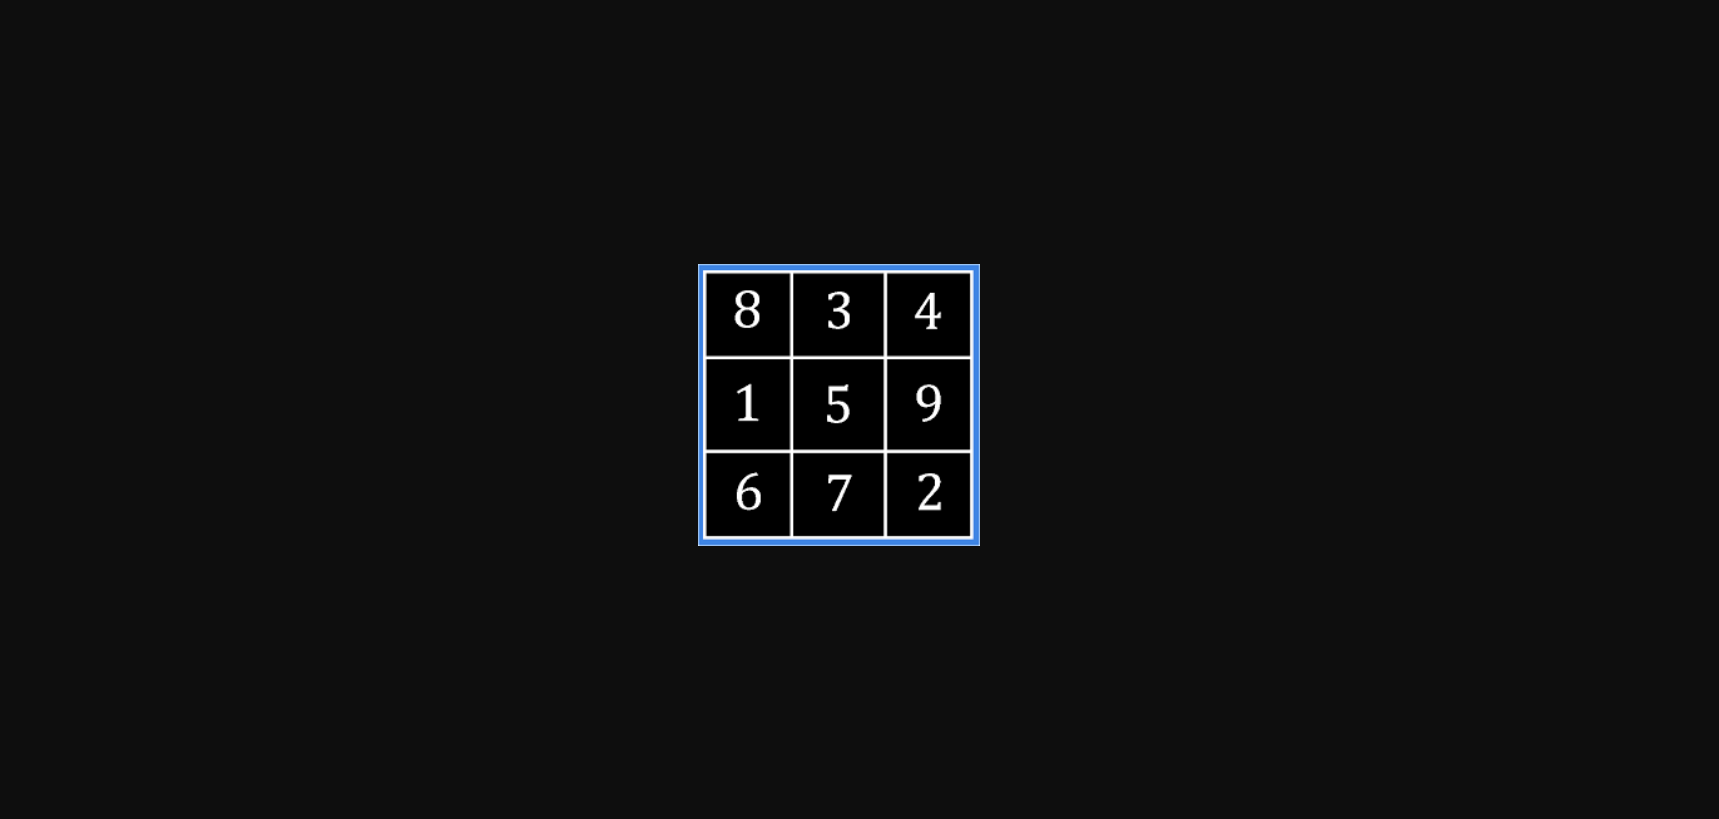

In [1]:
from random import choice
# let's play tic tac toe with the magic square knowledge background
import numpy as np
from itertools import combinations
from collections import namedtuple, defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

MAGIC = [2, 7, 6,
         9, 5, 1,
         4, 3, 8]

State = namedtuple('State', ['x', 'o'])

def win(elements):
  # check if the elements are winning
  # if any of the combinations of 3 numbers taken randomly from 1 to 9 is equal to 15
  return any(sum(c) == 15 for c in combinations(elements, 3))

def state_value(pos: State):
  # evaluate state: +1 first player wins
  if win(pos.x):
    return 1
  elif win(pos.o):
    return -1
  else:
    return 0

def print_board(pos):
  for row in range(3):
    for column in range(3):
      i = row * 3 + column
      if MAGIC[i] in pos.x:
        print('x', end='')
      if MAGIC[i] in pos.o:
        print('o', end='')
      else:
        print('_', end='')
    print()
  print()


In [2]:
def random_game():
  trajectory = list()
  state = State(set(), set())
  available = set(range(1, 9+1))

  while available:
    x = choice(list(available))
    state.x.add(x)
    trajectory.append(deepcopy(state))
    available.remove(x)
    if win(state.x) or not available:
      break


    o = choice(list(available))
    state.o.add(o)
    trajectory.append(deepcopy(state))
    available.remove(o)
    if win(state.o):
      break

  return trajectory

# main loop
value_dictionary = defaultdict(float)
hit_state = defaultdict(int)
epsilon = .001

for steps in tqdm(range(1000)):
  trajectory = random_game()
  final_reward = state_value(trajectory[-1])
  # it's a cumulative sum
  for state in trajectory:
    hashable_state = (frozenset(state.x), frozenset(state.o))
    hit_state[hashable_state] += 1 # times of the moves
    value_dictionary[hashable_state] = value_dictionary[hashable_state] + epsilon*(final_reward - value_dictionary[hashable_state])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [3]:
sorted(hit_state.items(), key = lambda e: e[1], reverse = True)[:10]

[((frozenset({4}), frozenset()), 127),
 ((frozenset({2}), frozenset()), 126),
 ((frozenset({8}), frozenset()), 126),
 ((frozenset({9}), frozenset()), 113),
 ((frozenset({1}), frozenset()), 109),
 ((frozenset({5}), frozenset()), 108),
 ((frozenset({7}), frozenset()), 102),
 ((frozenset({6}), frozenset()), 97),
 ((frozenset({3}), frozenset()), 92),
 ((frozenset({4}), frozenset({9})), 26)]

In [4]:
len(hit_state)

3218

## lab10 implementation: 2 players + RL

x ---> 1

o ---> 0

In [5]:
import random
# let's play tic tac toe with the magic square knowledge background
import numpy as np
from itertools import combinations
from collections import namedtuple, defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

State = namedtuple('State', ['x', 'o'])

MAGIC = [2, 7, 6,
         9, 5, 1,
         4, 3, 8]

def win(elements):
  # check if the elements are winning
  # if any of the combinations of 3 numbers taken randomly from 1 to 9 is equal to 15
  return any(sum(c) == 15 for c in combinations(elements, 3))

def state_value(pos: State):
  # evaluate state: +1 first player wins
  if win(pos.x):
    return 1
  elif win(pos.o):
    return 0
  else:
    return -1

def print_board(pos):
  for row in range(3):
    for column in range(3):
      i = row * 3 + column
      if MAGIC[i] in pos.x:
        print('x', end='')
      if MAGIC[i] in pos.o:
        print('o', end='')
      else:
        print('_', end='')
    print()
  print()


In the init function, we keep track of all positions the player’s been taken during each game in a list self.states and update the corresponding states in self.states_value dict. In terms of choosing action, we use ϵ-greedy method to balance between exploration and exploitation. Here we set exp_rate=0.3 , which means ϵ=0.3 , so 70% of the time our agent will take greedy action, which is choosing action based on current estimation of states-value, and 30% of the time our agent will take random action.

(https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542)

See also below that I set `epsilon = .003`.

In [6]:
class Agent:
  def __init__(self, x_or_o):
    self.x_or_o = x_or_o
    self.wins = 0
    self.value_dictionary = defaultdict(float)
    initial_lr = 0.2
    self.lr = initial_lr
    self.decay_gamma = 0.9

  def do_it_random(self, available, state):
    move = choice(list(available))
    current_state = deepcopy(state)
    current_state.x.add(move)
    # if (frozenset(state.x), frozenset(state.o)) not in self.value_dictionary.keys():
    self.value_dictionary[(frozenset(state.x), frozenset(state.o))] = epsilon
    return move

  def move(self, available, state):
    best_move = None
    if random.uniform(0, 1) <= epsilon:
      # do a random move
      move = self.do_it_random(available, state)
      best_move = move

    else:
      # if self.value_dictionary is not None:
        max_value = -999 # - infinite
        for move in available:
          current_state = deepcopy(state)
          current_state.x.add(move)
          hashable_state = (frozenset(state.x), frozenset(state.o))
          if hashable_state in self.value_dictionary.keys():
            value = self.value_dictionary[hashable_state]
            if value >= max_value:
              max_value = value
              best_move = move
        if best_move is None:
          move = self.do_it_random(available, state)
          best_move = move
      # else:
      #   move = self.do_it_random(self, available, state)
      #   best_move = move


    return best_move


  def feedReward(self, reward):
    hashable_state = (frozenset(state.x), frozenset(state.o))
    self.value_dictionary[hashable_state] += self.lr * (self.decay_gamma * reward - self.value_dictionary[hashable_state])
    reward = self.value_dictionary[hashable_state]
    self.lr *= self.decay_gamma
    return self.lr


In [7]:
class RandomPlayer:
  def __init__(self, x_or_o):
    self.x_or_o = x_or_o
    self.wins = 0
    self.value_dictionary = defaultdict(float)
    self.lr = 0.2
    self.decay_gamma = 0.9

  def move(self, available, state = None):
    return random.choice(list(available))

  def feedReward(self, reward):
    hashable_state = (frozenset(state.x), frozenset(state.o))
    self.value_dictionary[hashable_state] += self.lr * (self.decay_gamma * reward - self.value_dictionary[hashable_state])
    reward = self.value_dictionary[hashable_state]

In [14]:
def game(player1, player2):
  trajectory = list()
  state = State(set(), set())
  available = set(range(1, 9+1))

  players = [player1, player2]
  first_player = random.choice([0, 1])
  while available:
    current_player = players[first_player]

    move = current_player.move(list(available), state)

    # x = random.choice(list(available))
    if current_player.x_or_o == 1: # move = put a x
      state.x.add(move)
      trajectory.append(deepcopy(state))
      available.remove(move)
      if win(state.x) or not available:
        # current_player.wins += 1
        player2.wins += 1
        break

    else: # move = put a o
      # o = random.choice(list(available))
      state.o.add(move)
      trajectory.append(deepcopy(state))
      available.remove(move)
      if win(state.o):
        # current_player.wins += 1
        player1.wins += 1
        break

      first_player = 1 - first_player # if player 0 started, now it's the turn of player 1

  return trajectory


def give_reward(state, player1, player2):
  # result = win(state.x)
  if win(state.x): # x won
    player1.feedReward(1)
    fr = player2.feedReward(0)
  elif win(state.o): # o won
    player1.feedReward(0)
    fr =  player2.feedReward(1)
  else: # nobody won
    player1.feedReward(0)
    fr = player2.feedReward(0)
  return fr


# main loop
# value_dictionary = defaultdict(float)
hit_state = defaultdict(int)
epsilon = .003

player1 = RandomPlayer(0) # o
player2 = Agent(1) # x

matches = 10_000
# for steps in tqdm(range(matches)):
#   trajectory = game(player1, player2)
#   final_reward = state_value(trajectory[-1])
#   # it's a cumulative sum
#   for state in trajectory:
#     hashable_state = (frozenset(state.x), frozenset(state.o))
#     hit_state[hashable_state] += 1 # times of the moves
#     player2.value_dictionary[hashable_state] = player2.value_dictionary[hashable_state] + epsilon*(final_reward - player2.value_dictionary[hashable_state])
win_percentages = []
lrs = []
for steps in tqdm(range(matches)):
  trajectory = game(player1, player2)
  reward = give_reward((trajectory[-1]), player1, player2)
  lr = player2.feedReward(reward)
  lrs.append(lr)

  for state in trajectory:
    hashable_state = (frozenset(state.x), frozenset(state.o))
    hit_state[hashable_state] += 1 # times of the moves


    # reward = give_reward((trajectory[-1]), player1, player2)
    # if reward:
    #   player1.feedReward(reward)
    #   player2.feedReward(reward)
  win_percentages.append(player2.wins/matches*100)
print(f'The clever agent wins {player2.wins/matches*100}% times')

  0%|          | 0/10000 [00:00<?, ?it/s]

The clever agent wins 100.0% times


In [15]:
len(hit_state)

399

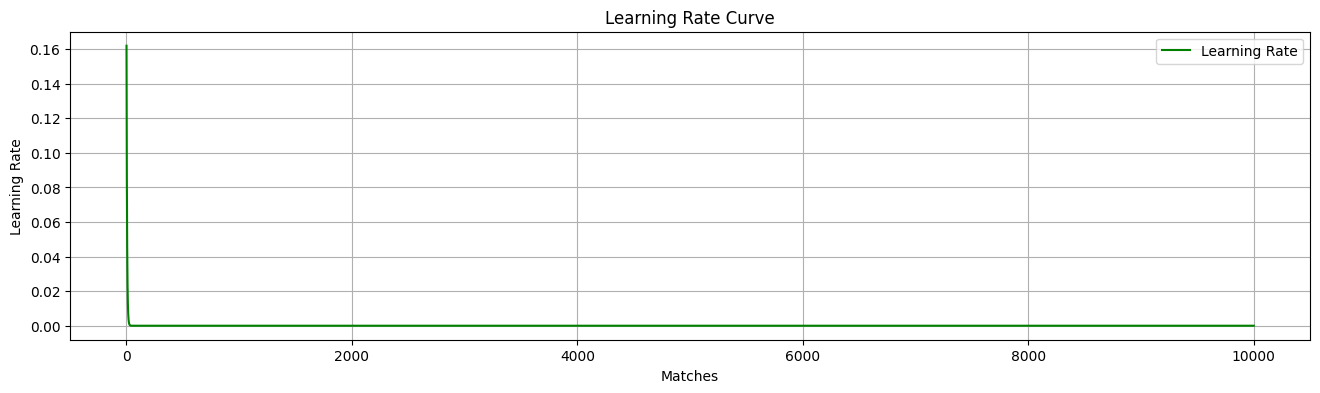

In [16]:
import matplotlib.pyplot as plt

def plot_learning_rate(learning_rates, title="Learning Rate Curve", xlabel="Matches", ylabel="Learning Rate"):
    """
    Plot the learning rate over time.

    Parameters:
    - learning_rates (list): List of learning rates over time.
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    """
    matches = list(range(1, len(learning_rates) + 1))

    plt.figure(figsize=(16, 4))
    plt.plot(matches, learning_rates, label='Learning Rate', color='g')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_rate(lrs)

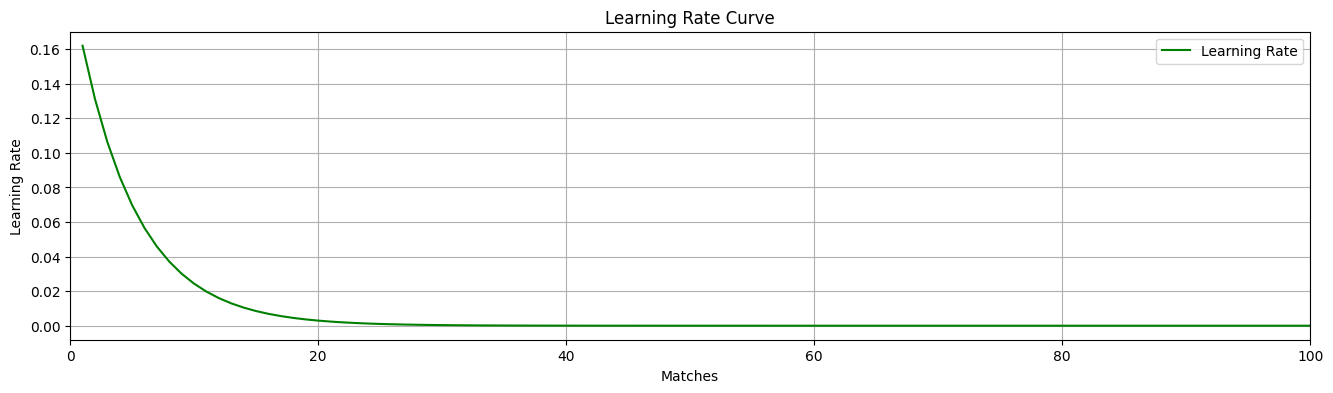

In [17]:
def plot_learning_rate(learning_rates, title="Learning Rate Curve", xlabel="Matches", ylabel="Learning Rate"):
    """
    Plot the learning rate over time.

    Parameters:
    - learning_rates (list): List of learning rates over time.
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    """
    matches = list(range(1, len(learning_rates) + 1))

    plt.figure(figsize=(16, 4))
    plt.plot(matches, learning_rates, label='Learning Rate', color='g')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, 100) # for better visualize the graph
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_rate(lrs)

________________________________________________________________________________________________